In [1]:
print('hello world!')

hello world!


In [2]:
%pylab inline

from __future__ import print_function

import skbio
from sklearn.feature_extraction import DictVectorizer
from skbio import Sequence
from collections import Counter
import numpy as np
from sklearn import datasets
from skbio import DNA
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


In [5]:
percent_id = 73

unaligned_ref_fp = 'gg_13_8_otus/rep_set/%d_otus.fasta' % percent_id
aligned_ref_fp = 'gg_13_8_otus/rep_set_aligned/%d_otus.fasta' % percent_id
tax_ref_fp = 'gg_13_8_otus/taxonomy/%d_otu_taxonomy.txt' % percent_id

In [7]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
fwd_primer = DNA("GTGCCAGCMGCCGCGGTAA", {'label':'fwd-primer'})
rev_primer = DNA("GGACTACHVGGGTWTCTAAT", {'label':'rev-primer'}).reverse_complement()

In [10]:
result = []
for c in fwd_primer:
    try:
        result.append('[%s]' % ''.join(DNA.degenerate_map[str(c)]))
    except KeyError:
        result.append(str(c))
result.append('.*')
for c in rev_primer:
    try:
        result.append('[%s]' % ''.join(DNA.degenerate_map[str(c)]))
    except KeyError:
        result.append(str(c))
        
regex = '(%s)' % ''.join(result)
print(regex)

(GTGCCAGC[AC]GCCGCGGTAA.*ATTAGA[AT]ACCC[CTG][ATG]GTAGTCC)


In [11]:
seq_count = 0
trimmed_seqs = []

for seq in skbio.io.read(unaligned_ref_fp, format='fasta'):
    seq_count += 1
    for i in seq.find_with_regex(regex):
        trimmed_seqs.append(seq[i])
print(seq_count, len(trimmed_seqs))

267 74


The above matches a lot of the sequences, but misses many of them because we're still doing an exact match search (even though several different sequences can match). 

In [12]:
seq_count = 0
trimmed_seqs = []
starts = []
stops = []

# how do we tell read to read into DNA sequence objects so we have access to gaps()
for seq in skbio.io.read(aligned_ref_fp, format='fasta'):
    seq = DNA(seq)
    seq_count += 1
    for i in seq.find_with_regex(regex, ignore=seq.gaps()):
        starts.append(i.start)
        stops.append(i.stop)
        
print(seq_count, len(trimmed_seqs))
print(min(starts))
print(mean(starts))
print(max(starts))
print(min(stops))
print(mean(stops))
print(max(stops))

267 0
2227
2227.0
2227
4090
4090.0
4090


In [13]:
mean_start = round(mean(starts))
mean_stop = round(mean(stops))
print(mean_start, mean_stop)

2227.0 4090.0


Since the min, mean, and max for start and stop are so close, we can just use the means to slice all of the aligned sequences, then degap them, and then train the classifier on those sequences instead of the full-length sequences. 

So now we get the kmer counts from our sequence region of interest for all of our input sequences (not just the ones where we had an exact primer match).

In [14]:
kmer_counts = []
seq_ids = []

for seq in skbio.io.read(aligned_ref_fp, format='fasta'):
    seq_ids.append(seq.metadata['id'])
    sliced_seq = DNA(seq[mean_start:mean_stop]).degap()
    sliced_kmer_frequencies = sliced_seq.kmer_frequencies(8)
    kmer_counts.append(dict(sliced_kmer_frequencies))

In [15]:
v = DictVectorizer(sparse=False)
D = kmer_counts
X = v.fit_transform(D)


In [16]:
taxa_dic = {}
with open(tax_ref_fp) as f:
    for line in f:
       (key, val) = line.strip().split('\t')
       taxa_dic[key] = val.split('; ')
        
    

In [25]:
y = np.array([taxa_dic[seq_id][0] for seq_id in seq_ids])

In [26]:
print(y.shape)
print(X.shape)

(267,)
(267, 25289)


In [27]:

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score, n_jobs=5)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}

Grid scores on development set:

0.801 (+/-0.045) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.801 (+/-0.045) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.922 (+/-0.135) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.829 (+/-0.111) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.922 (+/-0.135) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.964 (+/-0.043) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.964 (+/-0.043) for {'kernel': 'linear', 'C': 1}
0.964 (+/-0.043) for {'kernel': 'linear', 'C': 10}
0.964 (+/-0.043) for {'kernel': 'linear', 'C': 100}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

 k__Archaea       1.00      0.71      0.83        21
k__Bacteria       0.95      1.00      0.97       

Confusion matrix, without normalization
[[ 15   6]
 [  0 113]]


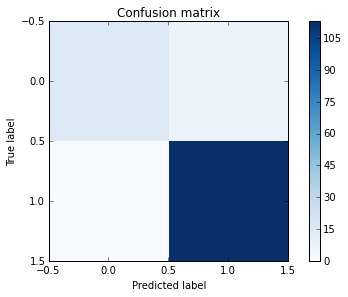

In [28]:
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)